# Классификация цветов

In [1]:
import os
import random

import matplotlib.pyplot as plt
import numpy as np
from copy import copy
from tqdm import tqdm

import torch
import torchvision
import torchvision.datasets as D
import torchvision.transforms as T
import torchvision.models as M
import sklearn.model_selection as ms
from torch.nn import functional as F
from torch.utils.data import DataLoader

print(torch.__version__)
print(torchvision.__version__)

2.1.2
0.16.2


## Подготовка данных

Возьмьем датасет с Kaggle — [Flowers Recognition](https://www.kaggle.com/alxmamaev/flowers-recognition).

Задача состоит в том, чтобы определять тип цветка (один из 5) по фотографии (всего их в датасете чуть больше четырех тысяч).

In [2]:
!ls /kaggle/input/flowers-recognition/flowers

daisy  dandelion  rose	sunflower  tulip


In [3]:
!find /kaggle/input/flowers-recognition/flowers -type f | wc -l

4317


Сформируем из данных датасет:

In [4]:
flowers_dataset = D.ImageFolder("/kaggle/input/flowers-recognition/flowers/")

Создадим объекты датасетов для обучения и валидации:

In [5]:
# Объявим сплиттер
sss = ms.StratifiedShuffleSplit(
    n_splits=1, test_size=512, random_state=2024
)

# Разделим ссылки на объекты и их метки
X = [x[0] for x in flowers_dataset.samples]
y = [x[1] for x in flowers_dataset.samples]

# Сплитование
train_idx, valid_idx = list(sss.split(X, y))[0]

print(len(train_idx), len(valid_idx))

3805 512


Теперь разделим датасет по подготовленным индексам

In [6]:
train_dataset = copy(flowers_dataset)
train_dataset.samples = [flowers_dataset.samples[i] for i in train_idx]
train_dataset.targets = [flowers_dataset.targets[i] for i in train_idx]
train_dataset.imgs = train_dataset.samples

valid_dataset = copy(flowers_dataset)
valid_dataset.samples = [flowers_dataset.samples[i] for i in valid_idx]
valid_dataset.targets = [flowers_dataset.targets[i] for i in valid_idx]
valid_dataset.imgs = valid_dataset.samples

print(len(train_dataset), len(valid_dataset))

3805 512


Посмотрим на примеры из обучения и валидации:

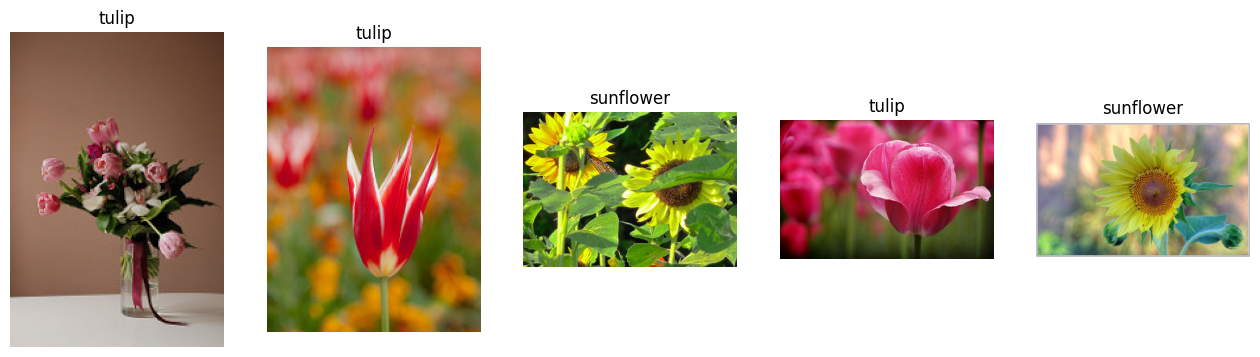

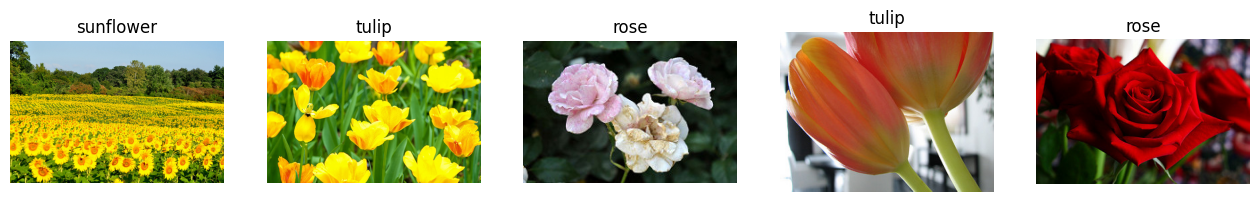

In [7]:
def plot_samples(dataset, num_samples=5):
    _, axes = plt.subplots(1, num_samples, figsize=(16, 8))

    for i in range(num_samples):
        random_image, random_class = random.choice(dataset)
        random_label = dataset.classes[random_class]
        axes[i].imshow(random_image)
        axes[i].set_title(random_label.replace("_", " "))
        axes[i].axis("off")

    plt.show()

plot_samples(train_dataset)
plot_samples(valid_dataset)

Определим также даталоадеры для обучения и валидации:

In [35]:
BATCH_SIZE = 64

normalize = T.Normalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225]
)

train_dataset.transform = T.Compose([
    T.RandomResizedCrop(224),
    T.RandomHorizontalFlip(),
    T.ToTensor(),
    normalize
])
valid_dataset.transform = T.Compose([
    T.Resize(256),
    T.CenterCrop(224),
    T.ToTensor(),
    normalize
])

train_loader = DataLoader(
    train_dataset, batch_size=BATCH_SIZE,
    shuffle=True, num_workers=os.cpu_count()
)

valid_loader = DataLoader(
    valid_dataset, batch_size=BATCH_SIZE,
    shuffle=False, num_workers=os.cpu_count()
)

## Обучение модели

In [36]:
model = M.resnet34()

total_params = sum(p.numel() for p in model.parameters())
print("Total parameters: ", total_params)

model.fc = torch.nn.Linear(512, len(train_dataset.classes))

criterion = torch.nn.CrossEntropyLoss()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
criterion = criterion.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)

Total parameters:  21797672


In [37]:
def train_model(net, optimizer, train_loader, valid_loader, num_epochs=10):
    loss_train = []
    top1_train = []
    loss_valid = []
    top1_valid = []

    for epoch in tqdm(range(num_epochs)):
        # переключаем torch в режим сохрания данных для рассчета градиентов
        torch.set_grad_enabled(True)
        # переключаем модель в режим обучения для хранения промежуточной информация
        net.train()

        losses = []
        equals = []

        for images, target in train_loader:
            # переносим на GPU при возможности
            images = images.to(device)
            target = target.to(device)

            # считаем сырые предсказания и функцию потерь
            output = net(images)
            loss = criterion(output, target)

            # запоминаем функцию потерь и правильность предсказаний
            losses.append(loss.item())
            equals.extend([eq.item() for eq in output.argmax(1) == target])

            # делаем шаг обновления весов модели
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        loss_train.append(np.mean(losses))
        top1_train.append(np.mean(equals))

        # для валидации градиенты не нужны
        torch.set_grad_enabled(False)
        # переключаем модель в режим валидации (быстрее, не храним ничего лишнего)
        net.eval()

        losses = []
        equals = []

        for images, target in valid_loader:
            # переносим на GPU при возможности
            images = images.to(device)
            target = target.to(device)

            # считаем сырые предсказания и функцию потерь
            output = net(images)
            loss = criterion(output, target)

            # запоминаем функцию потерь и правильность предсказаний
            losses.append(loss.item())
            equals.extend([eq.item() for eq in output.argmax(1) == target])

            # шаг обновления весов здесь не нужен
            ...

        loss_valid.append(np.mean(losses))
        top1_valid.append(np.mean(equals))

    return loss_train, top1_train, loss_valid, top1_valid

In [38]:
loss_train, top1_train, loss_valid, top1_valid = train_model(
    model, optimizer, train_loader, valid_loader, 50
)

100%|██████████| 50/50 [10:34<00:00, 12.68s/it]


## Анализ обученной модели

По умолчанию наш трейнер записывает логи обучения в формате TensorBoard в директории `lightning_logs/`.

Давайте запустим расширение `tensorboard` для ноутбука, чтобы отобразить его прямо здесь:

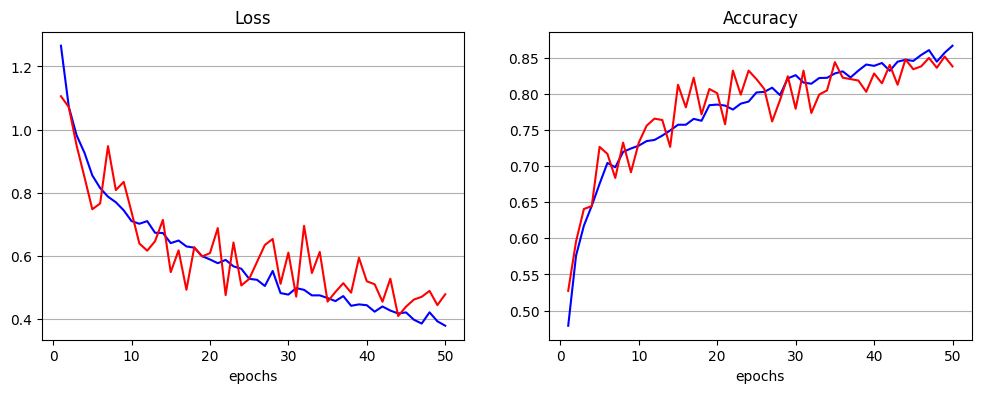

In [39]:
plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.plot(range(1, len(loss_train) + 1), loss_train, color="b")
plt.plot(range(1, len(loss_train) + 1), loss_valid, color="r")
plt.xlabel("epochs")
plt.title("Loss")
plt.grid(axis='y')
plt.subplot(122)
plt.plot(range(1, len(top1_train) + 1), top1_train, color="b")
plt.plot(range(1, len(top1_train) + 1), top1_valid, color="r")
plt.xlabel("epochs")
plt.title("Accuracy")
plt.grid(axis='y')

plt.show()

Видим, что и на обучении и на валидации было достигнуто качество в районе 85%.

Разумеется, модель можно попробовать улучшить, чтобы избавиться от осциляций в потерях и точности, но Kaggle, увы, зажимает время на ползование gpu-шками, google colab непредсказуем, а у меня на комбайне вовсе radeon :(

## Предсказание построенной моделью

Загрузим фото розы из интернета:

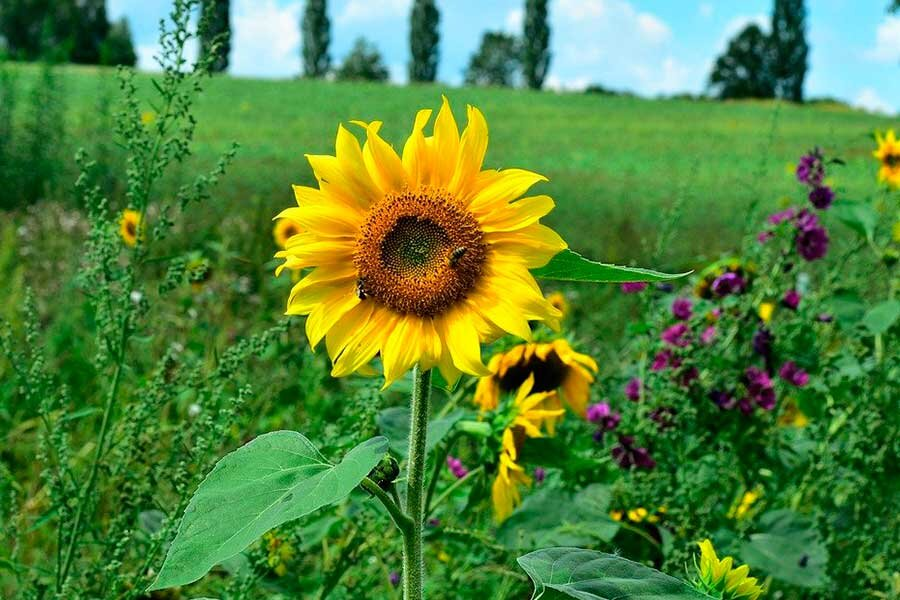

In [40]:
from PIL import Image
from skimage.io import imread

image = imread('https://avatars.dzeninfra.ru/get-zen_doc/4365012/pub_6087beb41ce94c64e6376121_6087d0386d7f5c727071294e/scale_1200')
PIL_image = Image.fromarray(image.astype('uint8'), 'RGB')
PIL_image

Сделаем предсказание для нашего изображение с помощью обученной модели:

In [41]:
tensor = valid_dataset.transform(PIL_image)
batch = torch.stack([tensor])
with torch.no_grad():
    output = model(batch.to(device)).to("cpu")
predicted = output.argmax().item()

Какому классу соответствует предсказание?

In [42]:
train_dataset.classes[predicted]

'sunflower'

Сработало!